<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from datetime import datetime
from dateutil import parser

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        sites_dict = pickle.load(f)
    sites_id=0
    sites_df = []
    
    for cur_dir, dirs, files in os.walk(path_to_csv_files):
        for file in files:
            t=pd.read_csv(path_to_csv_files+file)
            i_num=t.shape[0] # посещенных сайтов
            user_id=int(file[4:8]) # id user
            iter_num = 1+(i_num-1)//window_size
            bad_iter_num = 0 # сессии с нулями в конце
            for i in range(iter_num-1, -1, -1):
                if i*window_size+session_length > i_num:
                    bad_iter_num +=1
                else:
                    break
                
            sites = t.site.value_counts()            
            site_t = list(t.site)
            ts_0 = list(map(parser.parse, t.timestamp))
            ts = list(map(datetime.timestamp, ts_0))
            for i in range(iter_num-bad_iter_num): # большая часть итераций
                t_sites = site_t[window_size*i:window_size*i+session_length]
                unique = np.unique(t_sites).shape[0]
                
                start = ts_0[window_size*i]
                h_s, d_s = start.hour, start.weekday()                
                ts_s = []
                for ind in range(window_size*i, window_size*i+session_length-1):
                    ts_s.append(ts[ind+1]-ts[ind])                
                t_arr = t_sites + ts_s + [np.sum(ts_s), unique, h_s, d_s, user_id]
                sites_df.append(t_arr)
                
            for i in range(iter_num-bad_iter_num, iter_num):
                t_sites = site_t[window_size*i:]
                unique = np.unique(t_sites).shape[0]
                
                start = ts_0[window_size*i]
                h_s, d_s = start.hour, start.weekday()
                ts_s = []
                for ind in range(window_size*i, window_size*i+len(t_sites)-1 ):
                    ts_s.append(ts[ind+1]-ts[ind])                
                t_arr = t_sites+[0 for j in range(session_length-len(t_sites))]+ \
                        ts_s+[0 for j in range(session_length-len(ts_s)-1)] + \
                        [np.sum(ts_s), unique, h_s, d_s, user_id]
                sites_df.append(t_arr)
    # перевести названия в айди
    sites_df = [list(map(lambda x: x if not isinstance(x, str) else sites_dict[x][0], l)) for l in sites_df]
    sites_df = pd.DataFrame(sites_df, columns=feature_names)
    return(sites_df)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(PATH_TO_DATA+'/3users/', 
                  site_freq_path = PATH_TO_DATA+'/site_freq_3users.pkl',
                  feature_names=feature_names, session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,6,8,4,5,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2,12,4,1
2,3,2,9,9,2,0,0,0,0,0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3,9,4,2
3,10,1,2,1,2,1,1,8,11,10,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5,9,4,3
4,10,1,2,0,0,0,0,0,0,0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3,12,4,3


In [5]:
train_data_toy # check data

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [5]:
# %%time # Wall time: 27.1-31.3 s
train_data_10users = prepare_train_set_with_fe(PATH_TO_DATA+'/10users/', 
                  site_freq_path = PATH_TO_DATA+'/site_freq_10users.pkl',
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,101,65,10,4,10,10,4,10,78,10,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31
1,67,64,132,253,10,24,40,838,33,1,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31
2,1,4,1,1,8,85,67,99,216,1,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31
3,110,673,110,1,1,1,1,411,18,9,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31
4,102,1,8,542,32,30,780,308,105,308,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [7]:
# %%time # Wall time: 4min 35s
train_data_150users = prepare_train_set_with_fe(PATH_TO_DATA+'/150users/', 
                  site_freq_path = PATH_TO_DATA+'/site_freq_150users.pkl',
                  feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [8]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [9]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [10]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [11]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [12]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [13]:
''' ВАШ КОД ЗДЕСЬ ''' 
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

' ВАШ КОД ЗДЕСЬ '

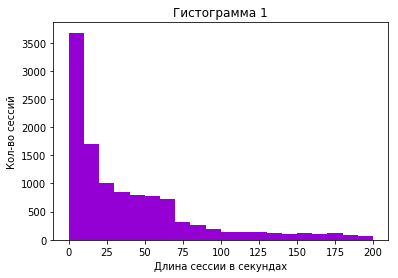

In [16]:
plt.hist( train_data_10users['session_timespan'], bins=[10*i for i in range(21)], color='darkviolet')
plt.gca().set(title='Гистограмма 1', xlabel='Длина сессии в секундах', ylabel='Кол-во сессий')
''' ВАШ КОД ЗДЕСЬ '''

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

' ВАШ КОД ЗДЕСЬ '

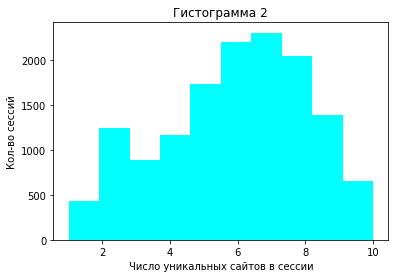

In [17]:
plt.hist( train_data_10users['#unique_sites'], color='aqua')
plt.gca().set(title='Гистограмма 2', xlabel='Число уникальных сайтов в сессии', ylabel='Кол-во сессий')
''' ВАШ КОД ЗДЕСЬ '''

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

' ВАШ КОД ЗДЕСЬ '

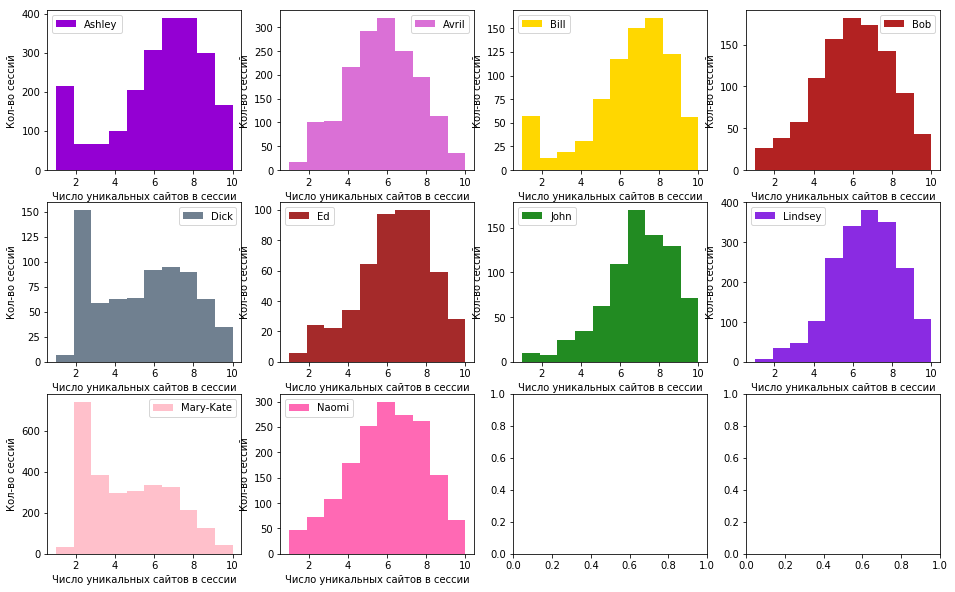

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[i][j].hist( sub_df['#unique_sites'], color=color_dic[user], label=user)
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('Число уникальных сайтов в сессии')
    axes[i][j].legend()
    if j==3:
        i+=1
        j=0
    else:
        j+=1
''' ВАШ КОД ЗДЕСЬ '''

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

' ВАШ КОД ЗДЕСЬ '

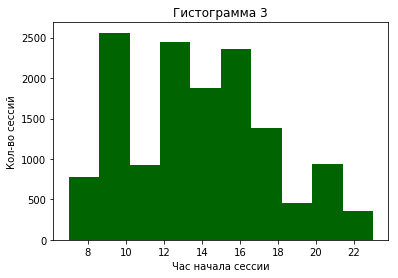

In [19]:
plt.hist( train_data_10users['start_hour'], color='darkgreen')
plt.gca().set(title='Гистограмма 3', xlabel='Час начала сессии', ylabel='Кол-во сессий')
''' ВАШ КОД ЗДЕСЬ '''

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

' ВАШ КОД ЗДЕСЬ '

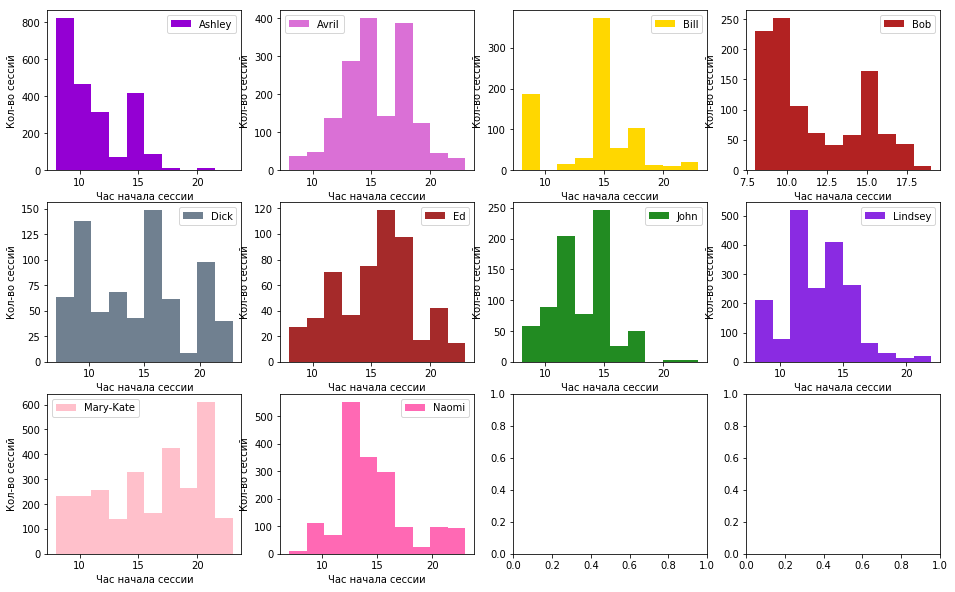

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[i][j].hist( sub_df['start_hour'], color=color_dic[user], label=user)
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('Час начала сессии')
    axes[i][j].legend()
    if j==3:
        i+=1
        j=0
    else:
        j+=1
''' ВАШ КОД ЗДЕСЬ '''

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

' ВАШ КОД ЗДЕСЬ '

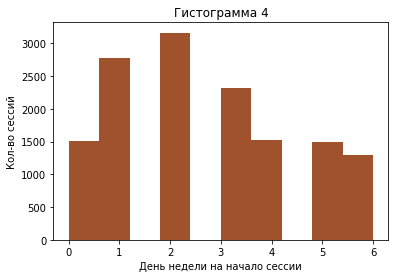

In [21]:
plt.hist( train_data_10users['day_of_week'], color='sienna')
plt.gca().set(title='Гистограмма 4', xlabel='День недели на начало сессии', ylabel='Кол-во сессий')
''' ВАШ КОД ЗДЕСЬ '''

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

' ВАШ КОД ЗДЕСЬ '

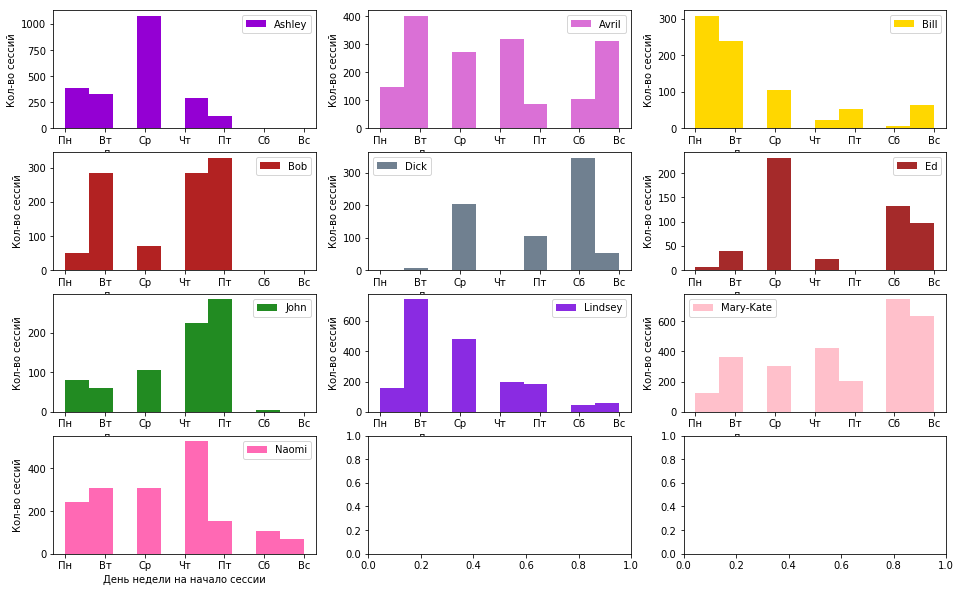

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[i][j].hist( sub_df['day_of_week'], color=color_dic[user], label=user, range=(0, 6))
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('День недели на начало сессии')
    axes[i][j].legend()
    axes[i][j].set_xticklabels(['t', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    if j==2:
        i+=1
        j=0
    else:
        j+=1
''' ВАШ КОД ЗДЕСЬ '''

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

1. 'Mary-Kate'. Периодически «зависает» на паре разных сайтов. Сидит в интернете в течение всего дня, вечером активность чуть больше. В течение рабочей недели активность равномерная, на выходных увеличивается.
2. 'Ashley'. Предпочитает разнообразие сайтов в сессии, но иногда «зависает» на одном сайте. Сидит в интернете в первой половине дня по будням, пик приходится на среду. 
3. 'Lindsey'. Предпочитает разнообразие сайтов в сессии. Сидит в интернете в первой половине дня, преимущественно по вторникам и средам.
4. 'Naomi'. Распределение числа уникальных сайтов чуть-чуть напоминает нормальное. Большую активность проявляет в середине дня. С пятницы по воскресенье почти не заходит в интернет.
5. 'Avril'. Распределение числа уникальных сайтов напоминает нормальное. Большую активность проявляет днем, распределение похоже на нормальное (за исключением перерыва на обед?). В течение недели активность проседает в понедельник, пятницу и субботу.
6. 'Bob'. Распределение числа уникальных сайтов напоминает нормальное. Предпочитает утреннюю активность в интернете, далее выделяется дневной всплеск (во время обеденного перерыва?). Большая часть сессий приходится на вторник, четверг и пятницу, в выходные не заходит в интернет.
7. 'Bill'. Предпочитает разнообразие сайтов в сессии, но иногда «зависает» на одном сайте. Выделяются всплески активности в интернете – ранним утром и днем. Большая часть сессий приходится на понедельник и вторник.
8. 'John'. Предпочитает разнообразие сайтов в сессии. Сидит в интернете в первой половине дня. Большая часть сессий приходится на четверг и пятницу, в выходные практически не заходит в интернет.
9. 'Dick'. Периодически «зависает» на паре разных сайтов. Сидит в интернете с утра до вечера, есть всплески активности. По дням приоритет приходится на среду, пятницу и субботу.
10. 'Ed'. Пик активности в интернете приходится на середину дня. Большая часть сессий приходится на среду и выходные.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [23]:
with open('capstone_user_identification/site_freq_10users.pkl', 'rb') as f:
    data = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [24]:
list_d = list(data.items())
list_d.sort(key=lambda i: i[1][1], reverse=True)

top10_freqs = [i[1][1] for i in list_d[0:10]]
top10_sites = [i[0] for i in list_d[0:10]]
print (top10_freqs, top10_sites)

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089] ['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

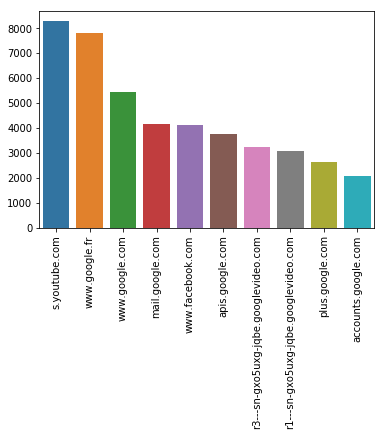

In [25]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation='vertical')

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [26]:
'''def feature_engineering(path_to_csv_files, features, session_length=10):
    
    ВАШ КОД ЗДЕСЬ
    ''' 
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    with open(site_freq_path, 'rb') as f:
        sites_dict = pickle.load(f)
    sites_df = []
    
    for cur_dir, dirs, files in os.walk(path_to_csv_files):
        for file in files:
            t=pd.read_csv(path_to_csv_files+file)
            i_num=t.shape[0] # посещенных сайтов
            user_id=int(file[4:8]) # id user
            iter_num = i_num//session_length + int(i_num%session_length!=0) # sessions num
            sites = t.site.value_counts()
            
            site_t = list(t.site)            
            ts_0 = list(map(parser.parse, t.timestamp))
            ts = list(map(datetime.timestamp, ts_0))
            
            for i in range(iter_num-1): # большая часть итераций
                t_sites = site_t[session_length*i:session_length*(i+1)]
                ts_s = []
                for ind in range(session_length*i, session_length*i+len(t_sites)-1):
                    ts_s.append(ts[ind+1]-ts[ind])
                t_1, t_2, t_3 = np.min(ts_s), np.median(ts_s), np.max(ts_s) # time features  
                t_arr = [t_1, t_2, t_3]             
                
                elems = ['twitter', 'facebook', 'google', 'youtube', 'mail', 'disk', 'drive',
                        'box', 'cloud', 'docs', 'video', '.org', '.net', '.fr', '.de', '.uk', '.cn', '.ru']
                for elem in elems:
                    res_elem = 0
                    for s_t in t_sites:
                        if elem in s_t:
                            res_elem +=1
                    t_arr += [res_elem]
                t_arr += [np.sum(t_arr[8:13])]+[user_id]
                sites_df.append(t_arr)
            
            t_sites = site_t[session_length*(iter_num-1):]
            ts_s = []
            for ind in range(session_length*(iter_num-1), session_length*(iter_num-1)+len(t_sites)-1):
                ts_s.append(ts[ind+1]-ts[ind])
            if len(ts_s) != 0:
                t_1, t_2, t_3 = np.min(ts_s), np.median(ts_s), np.max(ts_s)
            else:
                t_1, t_2, t_3 = 0, 0, 0 # time features
            t_arr = [t_1, t_2, t_3]

            elems = ['twitter', 'facebook', 'google', 'youtube', 'mail', 'disk', 'drive',
                    'box', 'cloud', 'docs', 'video', '.org', '.net', '.fr', '.de', '.uk', '.cn', '.ru']
            for elem in elems:
                res_elem = 0
                for s_t in t_sites:
                    if elem in s_t:
                        res_elem +=1
                t_arr += [res_elem]            
            t_arr += [np.sum(t_arr[8:13])]+[user_id]
            sites_df.append(t_arr)
    sites_df = pd.DataFrame(sites_df, columns=features)
    return sites_df

In [27]:
feature_names = ['t_min', 't_median', 't_max', 'twitter', 'facebook', 'google', 'youtube', 'mail', 'disk', 'drive',
                'box', 'cloud', 'docs', 'video', '.org', '.net', '.fr', '.de', '.uk', '.cn', '.ru', 'docs_sum', 'target']
my_features_10users = feature_engineering(PATH_TO_DATA+'/10users/', 
                  site_freq_path = PATH_TO_DATA+'/site_freq_10users.pkl',
                  features=feature_names, session_length=10)
my_features_10users['target'] = my_features_10users['target'].map(id_name_dict)

In [28]:
my_features_10users.head()

,t_min,t_median,t_max,twitter,facebook,google,youtube,mail,disk,drive,box,cloud,docs,video,.org,.net,.fr,.de,.uk,.cn,.ru,docs_sum,target
0,0.0,1.0,20.0,0,0,2,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,John
1,0.0,3.0,163.0,0,0,1,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,John
2,0.0,0.0,242.0,0,1,1,0,4,0,0,0,0,0,0,0,4,0,0,0,0,0,0,John
3,0.0,1.0,25.0,0,0,0,0,4,0,0,0,0,0,0,0,8,0,0,0,0,0,0,John
4,0.0,1.0,1.0,0,1,0,0,1,0,0,0,0,0,0,1,4,0,0,0,0,2,0,John


[0.47910448 0.46224403 0.47063848]


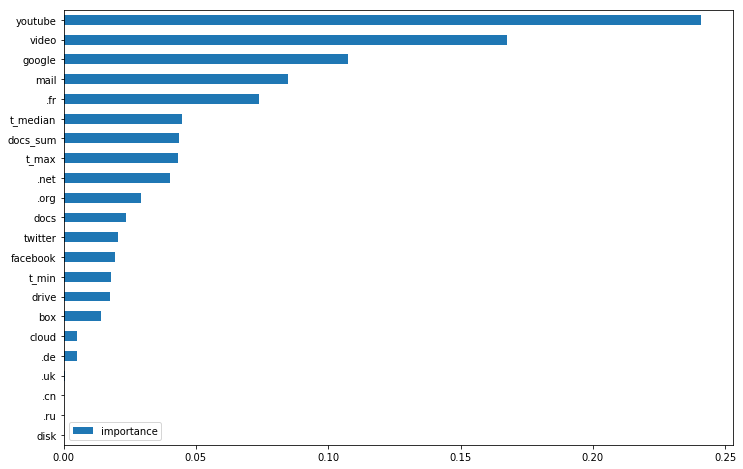

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators = 100, max_depth = 7)
test_data = my_features_10users.sample(frac=1)
X = test_data.drop('target', axis=1)
y = test_data.target
print (cross_val_score(forest, X, y, cv=3) )

forest.fit(X, y)
imp = pd.DataFrame(forest.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [30]:
my_features_150users = feature_engineering(PATH_TO_DATA+'/150users/', 
                  site_freq_path = PATH_TO_DATA+'/site_freq_150users.pkl',
                  features=feature_names, session_length=10)

[0.1245845  0.12680096 0.12689332]


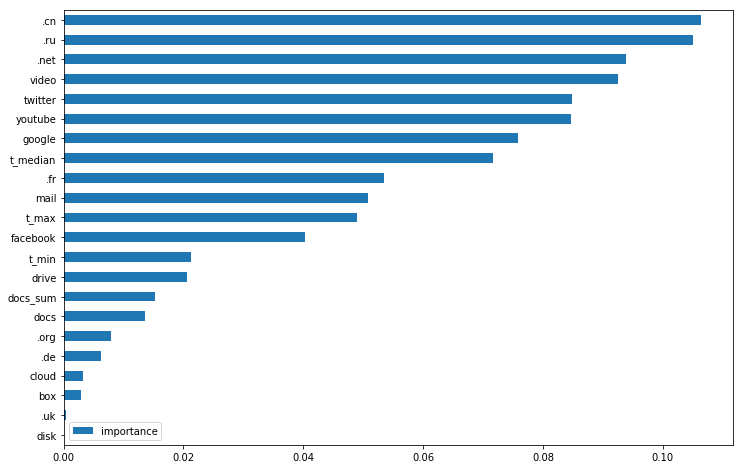

In [39]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 7)
test_data = my_features_150users.sample(frac=1)
X = test_data.drop('target', axis=1)
y = test_data.target
print (cross_val_score(forest, X, y, cv=3) )

forest.fit(X, y)
imp = pd.DataFrame(forest.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Построим картинки для трех лучших признаков с выборки по 10 пользователям

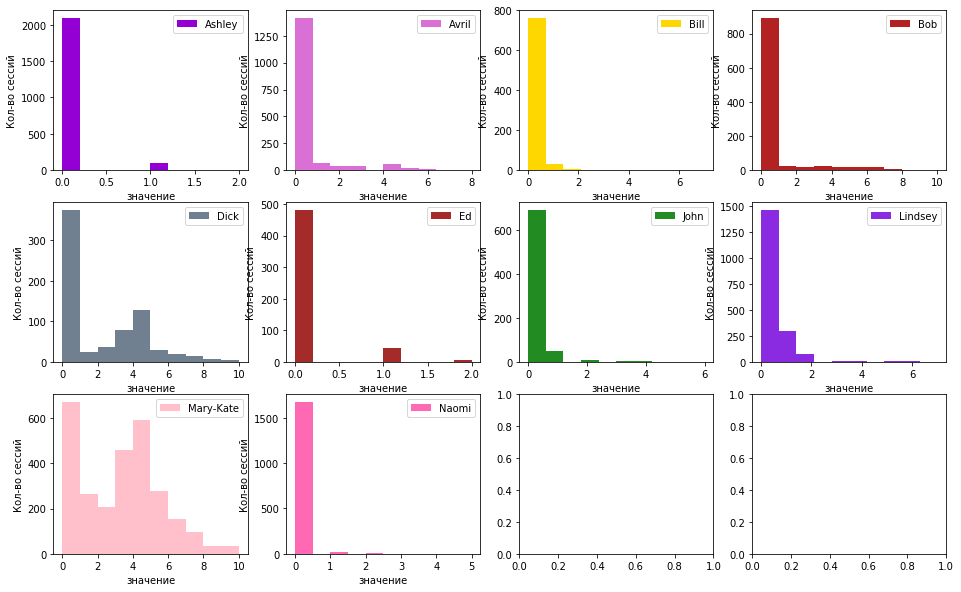

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(my_features_10users.groupby('target')): 
    axes[i][j].hist( sub_df['youtube'], color=color_dic[user], label=user) # меняем признак для отображения
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('значение')
    axes[i][j].legend()
    if j==3:
        i+=1
        j=0
    else:
        j+=1

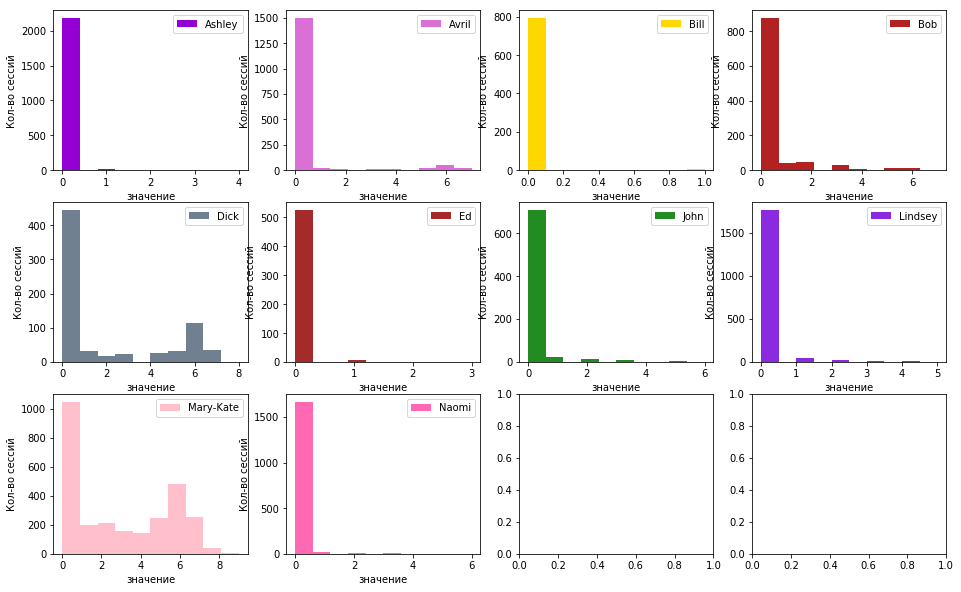

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(my_features_10users.groupby('target')): 
    axes[i][j].hist( sub_df['video'], color=color_dic[user], label=user) # меняем признак для отображения
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('значение')
    axes[i][j].legend()
    if j==3:
        i+=1
        j=0
    else:
        j+=1

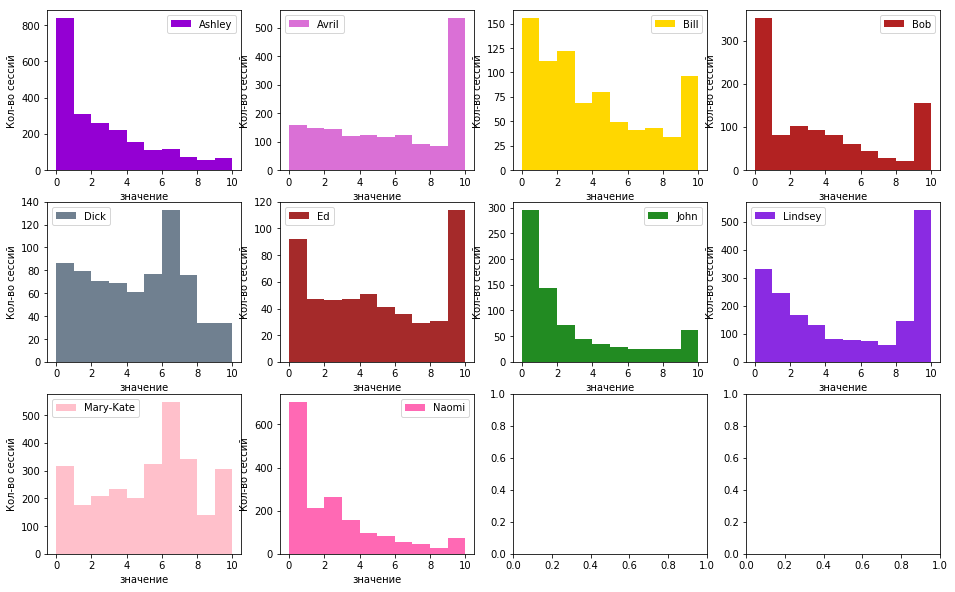

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
i,j = 0, 0
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(my_features_10users.groupby('target')): 
    axes[i][j].hist( sub_df['google'], color=color_dic[user], label=user) # меняем признак для отображения
    axes[i][j].set_ylabel('Кол-во сессий')
    axes[i][j].set_xlabel('значение')
    axes[i][j].legend()
    if j==3:
        i+=1
        j=0
    else:
        j+=1

### Мы можем заметить, что
1. Результаты классификации случайным лесом по введенным признакам не впечатляют, но значительно превосходят ситуацию с случайным выбором класса ( p(user_i) = #(user_i sessions) / #(all sessions) )
2. Значимость признаков на выборках с 10 и 150 юзерами существенно различается. Несущественными стоит признать признаки t_min (очевидно, зачастую равную 0), а также признаки, сумму которых хранит признак docs_sum (это признаки 'disk', 'drive', 'box', 'cloud', 'docs')

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [35]:
selected_features_10users = new_features_10users
selected_features_150users = new_features_150users

created_features = ['t_median', 't_max', 'twitter', 'facebook', 'google', 'youtube', 'mail',
                    'video', '.org', '.net', '.fr', '.de', '.uk', '.cn', '.ru', 'docs_sum']
for t in created_features:
    selected_features_10users[t] = my_features_10users[t]
    selected_features_150users[t] = my_features_150users[t]
selected_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,t_median,t_max,twitter,facebook,google,youtube,mail,video,.org,.net,.fr,.de,.uk,.cn,.ru,docs_sum
0,33.0,5,8,4,1.0,20.0,0,0,2,0,0,0,0,7,0,0,0,0,0,0
1,284.0,10,8,4,3.0,163.0,0,0,1,0,1,0,0,3,0,0,0,0,0,0
2,258.0,7,8,4,0.0,242.0,0,1,1,0,4,0,0,4,0,0,0,0,0,0
3,30.0,6,8,4,1.0,25.0,0,0,0,0,4,0,0,8,0,0,0,0,0,0
4,6.0,9,8,4,1.0,1.0,0,1,0,0,1,0,1,4,0,0,0,0,2,0


In [36]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 